## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import itertools

#Scikit learn imports:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Data Prep

In [2]:
data_path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
#This is a string for some ungodly reason

In [5]:
print(type(df['TotalCharges'][0]))
df.head()

<class 'numpy.float64'>


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
encode_df = df.drop(['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges'],  axis = 1)

In [7]:
le = LabelEncoder()

In [8]:
encoded_df = encode_df.apply(le.fit_transform)

In [9]:
encoded_df[['tenure', 'MonthlyCharges', 'TotalCharges']] = df[['tenure', 'MonthlyCharges', 'TotalCharges']]

In [10]:
encoded_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,1,29.85,29.85
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,34,56.95,1889.50
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,2,53.85,108.15
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,45,42.30,1840.75
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,2,70.70,151.65


In [11]:
X = encoded_df.drop(['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges'], axis = 1)
y = encoded_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 7)

Data's ready, time for

## FSMs

The plan is to run a KNN, randomforest, and decision tree classifier w/o anything fancy for now.

Starting w/ KNN

In [12]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 2)

In [13]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [14]:
knn_pred = knn.predict(X_test)
knn_acc = metrics.accuracy_score(y_test, knn_pred)

print("predictions: ", knn_pred)
print("accuracy: ", knn_acc)

predictions:  [0 1 0 ... 0 0 0]
accuracy:  0.7473385379701917


Not bad for an fsm, will ss the floats next time for all of these

Decision tree, making validation data as this guy will likely overfit

In [15]:
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=7, test_size = .15)

In [16]:
dt = DecisionTreeClassifier()
dt.fit(X_t, y_t)

dt_y_hat_val = dt.predict(X_val)
print(f'Training Score: {dt.score(X_t, y_t)}')
print(f'Val      Score: {dt.score(X_val, y_val)}')

Training Score: 0.9273182957393483
Val      Score: 0.710401891252955


Confusion Matrix, without normalization
[[509 121]
 [124  92]]


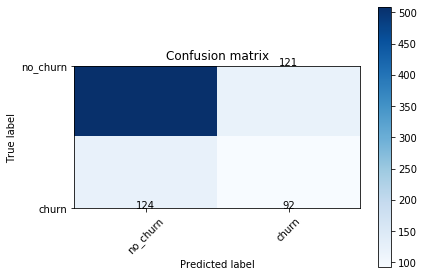

In [24]:
from src.confusion import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
plot_confusion_matrix(confusion_matrix(y_val, dt_y_hat_val),classes=['no_churn', 'churn'])

Why are you so squished? If I can figure out whats wrong I'll fix this later, but its not important right now. 

Overfit, going for its couzin now

Random Forest

In [47]:
rf = RandomForestClassifier()
rf.fit(X_t, y_t)

y_hat_val = rf.predict(X_val)
print(f'Training Score: {rf.score(X_t, y_t)}')
print(f'Val      Score: {rf.score(X_val, y_val)}')

/Users/adamroth/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Score: 0.9154135338345865
Val      Score: 0.7565011820330969


Next plan of attack is to try out some regularization and/or use standard scaler on the floats